In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
from PIL import Image
import os
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu
from sklearn.metrics import jaccard_similarity_score

Using TensorFlow backend.


In [2]:
# set paths
mlo_image_path = '/home/yannan_lin/unet/MLO_image/'
mlo_mask_path = '/home/yannan_lin/unet/MLO_mask/'

test_image_path = '/home/yannan_lin/unet/test_image/'
test_gt_path = '/home/yannan_lin/unet/test_gt/'
test_result_path = '/home/yannan_lin/unet/test_result/'

model_path = '/home/yannan_lin/unet/'

image_path = glob.glob("%s/*.jpg" % mlo_image_path)
mask_path = glob.glob("%s/*.jpg" % mlo_mask_path)

test_path = glob.glob("%s/*.jpg" % test_image_path)
truth_path = glob.glob("%s/*.jpg" % test_gt_path)
result_path = glob.glob("%s/*.jpg" % test_result_path)

side_length = 128

In [3]:
# define functions

def create_train_data(image_path, mask_path, side_length): 
    """
    Function to create traning data
    
    input: image_path, mask_path, side_length
    output: image_list, binary_mask_list, name_list
    
    This function taks the path to the images, the path to 
    the masks, and the side length as input parameters and 
    outputs the following:
    
    image_list is a list of MLO images.
    binary_mask_list is a list of masks corresponsing to 
    the images in image_list.
    name_list is a list of names of MLO images.
    
    """
    name_list = []
    image_list = []
    binary_mask_list = []

    for i in range(len(image_path)): 
        print(i)
        name = image_path[i].split("/")[-1]
        image_name = name.split(".")[0]
        name_list.append(name)
        
        image = Image.open(image_path[i])
        image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2GRAY)
        image = cv2.resize(np.asarray(image), (side_length,side_length))
        
        mask = Image.open(mask_path[i])
        mask = cv2.cvtColor(np.asarray(mask), cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(np.asarray(mask), (side_length,side_length))
        try:
            thresh = threshold_otsu(mask)
            mask = np.where(mask>thresh, 1.0, 0.0)
        except:
            for x in range(side_length):
                for y in range(side_length):
                    if mask[x,y]==255:
                        mask[x,y] = 1

        image_list.append(image)
        binary_mask_list.append(mask)

    return image_list, binary_mask_list, name_list

def rotate(image, angle):
    """
    Function to rotate an image
    
    input: image, angle
    output: dst
    
    This function takes an image and an angle as inputs,
    and output an rotated image according to the specifed
    angle.
    
    """
    rows,cols = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst    
   
def rotate_images(img_list, mask_list):
    """
    Function to rotate two lists of images
    
    input: img_list, mask_list
    output: img_list_rotate, mask_list_rotate
    
    This function takes an image list and a mask list
    and rotate 90, 180, 270 degrees. The output is 
    two lists of rotated images.
    
    """
    rotate_angle_list = [180]
    img_list_rotate = list()
    mask_list_rotate = list()
    for i in range(len(img_list)):
        for j in range(len(rotate_angle_list)):    
            img = img_list[i]
            mask = mask_list[i]
            
            rotated_img = rotate(img, rotate_angle_list[j])
            rotated_mask = rotate(mask, rotate_angle_list[j])
            
            img_list_rotate.append(rotated_img)
            mask_list_rotate.append(rotated_mask)
            
    return img_list_rotate, mask_list_rotate

def flip(img_list, mask_list):
    """
    Function to flip two lists of images
    
    input: img_list, mask_list
    output: img_list_fliplr, mask_list_fliplr, img_list_flipud, mask_list_flipud
    
    This function takes an image list and a mask list as input, which will 
    be flipped twice. The output is four lists of filpped images.
    
    """
    img_list_fliplr = list()
    img_list_flipud = list()
    mask_list_fliplr = list()
    mask_list_flipud = list()
    for i in range(len(img_list)):
        flipped_img = np.fliplr(img_list[i])
        flipped_mask = np.fliplr(mask_list[i])
        img_list_fliplr.append(flipped_img)
        mask_list_fliplr.append(flipped_mask)
        
        flipped_img_2 = np.flipud(img_list[i])
        flipped_mask_2 = np.flipud(mask_list[i])
        img_list_flipud.append(flipped_img_2)
        mask_list_flipud.append(flipped_mask_2)
    return img_list_fliplr, mask_list_fliplr, img_list_flipud, mask_list_flipud

def unet(input_size = (side_length,side_length,1)):
    """
    Function to build u-net model
    
    input: input_size = (side_length,side_length,1)
    output: model
    
    This function takes input size of the training data as input
    and outputs the model structure for training. 
    
    """
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()
    
    print("model done")

    return model

def plot_acc_loss(history):
    """
    Function to plot loss and accuracy during training and validation
    
    input: history
    output: a plot of train and validation loss and accuracy
    
    This function plots the loss and accuarcy during training and 
    validation using history, which is the training result. 
    
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']

    plt.figure()
    plt.plot(train_loss, label = 'train loss')
    plt.plot(val_loss, label = 'val loss')
    plt.plot(train_acc, label = 'train acc')
    plt.plot(val_acc, label = 'val acc')
    plt.legend(bbox_to_anchor=(1.05,1),loc=2)  
    return plt.show()

def read_test_images(test_path, truth_path, side_length):
    """
    Function to read in testing images
    
    input: test_path, truth_path, side_length
    output: test_image_list, test_gt_list
    
    This function reads in paths for testing images and their 
    ground truth images along with the side length of the image
    and outputs a list of testing images and ground truth images 
    in numpy array format.
    
    """
    # read test images
    test_image_list = []
    for i in range(len(test_path)):
        image = Image.open(test_path[i])
        image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2GRAY)
        image = cv2.resize(np.asarray(image), (side_length,side_length))
        test_image_list.append(image)

    # read ground truth
    test_gt_list = []
    for i in range(len(truth_path)):
        mask = Image.open(truth_path[i])
        mask = cv2.cvtColor(np.asarray(mask), cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(np.asarray(mask), (side_length,side_length))
        try:
            thresh = threshold_otsu(mask)
            mask = np.where(mask>thresh, 1.0, 0.0)
        except:
            for x in range(side_length):
                for y in range(side_length):
                    if mask[x,y]==255:
                        mask[x,y] = 1
        test_gt_list.append(mask)
    return test_image_list, test_gt_list


def test_model(test_path, test_image_path, test_image_list, 
               test_result_path, side_length,model_path):
    """
    Function to test the model
    
    input: test_path, test_image_path, test_image_list, 
           test_result_path, side_length,model_path
    output: save the predicted image to a path
    
    This function inputs the testing images and generates
    prediction results, which will be saved to the test result path.
    
    test_path is the path to the test images
    test_image_path is a list of paths of the test images
    test_image_list is a list of test images
    test_result_path is the path to the test results
    model_path is the path to the saved model
    side_length is the side length of the images
    
    """
        
    model = load_model(os.path.join(model_path+'model.h5'))
    
    for i in range(len(test_image_list)):
        name = test_path[i].split("/")[-1]
        image_name = name.split(".")[0]
        test_img =test_image_list[i]
        test_img = test_img.reshape((1,side_length,side_length,1))
        preds_test = model.predict(test_img, verbose=0)
        preds_test_t = (preds_test > 0.7).astype(np.uint8)
        test_result = np.squeeze(preds_test_t)
        
        matplotlib.image.imsave(os.path.join(test_result_path+image_name+'.jpg'), test_result)
        
def print_test_result(index,threshold,model_path,
                      test_image_list, test_gt_list,
                      side_length):
    """
    Function to print out an example of test result
    
    input: index,threshold,model_path,
           test_image_list, test_gt_list, side_length)
    output: plot three images
    
    This function allows an user to select their own test image
    by specifying index. The threshold can be tuned also in the 
    input. The output of this function consists of three images:
    the test image, the ground truth image of the test image, 
    and the predicted image of the test image.
    
    Additional fixed input parameters include:
    model_path is the path to the saved model
    test_image_list is a list of test images
    test_gt_list is a list of ground truth images for the test images
    side_length is the side length of the images
        
    """
    model = load_model(os.path.join(model_path+'model.h5'))

    test_img = test_image_list[index].reshape((1,side_length,side_length,1))

    preds_test = model.predict(test_img, verbose=1)

    preds_test_t = (preds_test > threshold).astype(np.uint8)

    plt.imshow(test_image_list[index], cmap="gray")
    plt.show()
    plt.imshow(test_gt_list[index], cmap="gray")
    plt.show()
    plt.imshow(np.squeeze(preds_test_t), cmap="gray")
    plt.show()
    
def read_test_results(result_path, side_length):
    """
    Function to read in test results
    
    input: result_path, side_length
    output: test_result_list
    
    This function reads in paths for test results 
    and outputs a list of predicted images in numpy 
    array format.
    
    side_length is the side length of the images
    
    """
    # read test result
    test_result_list = []
    for i in range(len(result_path)):
        image = Image.open(result_path[i])
        image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2GRAY)
        image = cv2.resize(np.asarray(image), (side_length,side_length))
        try:
            thresh = threshold_otsu(image)
            image = np.where(image>thresh, 1.0, 0.0)
        except:
            for x in range(side_length):
                for y in range(side_length):
                    if image[x,y]==255:
                        image[x,y] = 1

        test_result_list.append(image)
    return test_result_list

def mean_iou(test_gt_list, test_result_list):
    """
    Function to calculate Jaccard index

    input: test_gt_list, test_result_list
    output: iou_list, mean_iou
    
    This function takes in the test groud truth list and 
    the test result list. For each ground truth and prediction
    pair, the Jaccard index will be calculated and saved to
    iou_list. The mean iou of all the testing pairs will 
    also be returned together with the iou_list.
    
    """
    iou_list = []
    for i in range(len(test_gt_list)):
        truth = test_gt_list[i]
        pred = test_result_list[i]     
        iou = jaccard_similarity_score(truth.ravel(), pred.ravel())
        iou = round(iou, 2)
        iou_list.append(iou)
    
    mean_iou = np.mean(iou_list)
    
    return iou_list, mean_iou

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

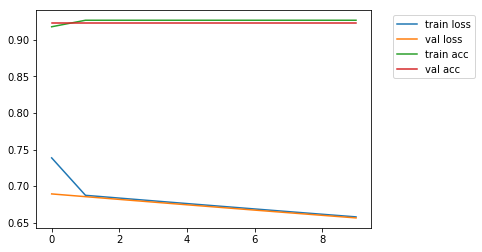

In [4]:
##### training #####

# create train data
image_list, binary_mask_list, name_list = create_train_data(image_path, mask_path, side_length)

#rotate images
img_list_rotate = rotate_images(image_list, binary_mask_list)[0]
mask_list_rotate = rotate_images(image_list, binary_mask_list)[1]

#flip images
img_list_fliplr = flip(image_list, binary_mask_list)[0]
mask_list_fliplr = flip(image_list, binary_mask_list)[1]
img_list_flipud = flip(image_list, binary_mask_list)[2]
mask_list_flipud = flip(image_list, binary_mask_list)[3]
        
#concatenate img and mask lists
img_list_whole = image_list+img_list_rotate+img_list_fliplr+img_list_flipud
mask_list_whole = binary_mask_list+mask_list_rotate+mask_list_fliplr+mask_list_flipud

# split train and test data
x_train, x_test, y_train, y_test = train_test_split(img_list_whole, mask_list_whole, test_size=0.2, random_state=42)

# resize train and test data
x_train = np.asarray([x_train[i].reshape([side_length,side_length,1]) for i in range(len(x_train))])
x_test = np.asarray([x_test[i].reshape([side_length,side_length,1]) for i in range(len(x_test))])

y_train = np.asarray([y_train[i].reshape([side_length,side_length,1]) for i in range(len(y_train))])
y_test = np.asarray([y_test[i].reshape([side_length,side_length,1]) for i in range(len(y_test))])

# compile and train model
model = unet(input_size = (side_length,side_length,1))

callbacks = [
EarlyStopping(patience=20, verbose=1),
ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
ModelCheckpoint(os.path.join(model_path+'model.h5'), verbose=1, save_best_only=True)
]

# train model
history = model.fit(x_train, y_train, batch_size=16, epochs=100, callbacks=callbacks,
validation_data=(x_test, y_test))

# plot tranin and validation loss & acc
plot_acc_loss(history)

1/1 [==============================] - 0s 407ms/step


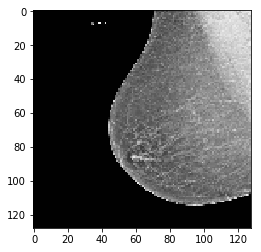

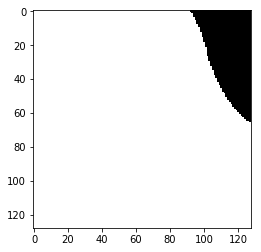

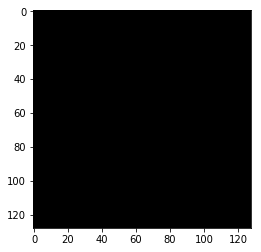

In [5]:
###### testing #####

# read test data
test_image_list, test_gt_list = read_test_images(test_path, truth_path, side_length)

# test model using test images
test_model(test_path, test_image_path, test_image_list, 
               test_result_path, side_length,model_path)

# print test results
print_test_result(0,0.7,model_path,
                  test_image_list, test_gt_list,
                  side_length) # 0 is index, 0.7 is threshold

In [6]:
######### evaluation ########

# read test results
test_result_list = read_test_results(result_path, side_length)

# print jaccard index
iou_list, mean_iou = mean_iou(test_gt_list, test_result_list)
print(iou_list)
print(mean_iou)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0
